In [1]:
from typing import Callable
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
%matplotlib inline

pd.set_option('display.precision', 4)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
np.set_printoptions(formatter={'all': lambda x: '%.4f' % x})

In [2]:
def mse(theta:np.ndarray, x:np.ndarray, y: np.ndarray) -> float:
    y1 = np.dot(x, theta)
    return np.sum((y1 - y) ** 2) / y.shape[0]

def mse_gradient(theta:np.ndarray, x:np.ndarray, y: np.ndarray, debug: bool = False) -> np.ndarray:
    y1 = np.dot(x, theta)
    return np.dot(np.transpose(x), (y1 - y)) * (2 / y.shape[0])

def descenso_gradiente_con_momentum_adam(
    x: np.ndarray,
    y: np.ndarray,
    grad_fn: Callable = mse_gradient,
    alpha: float = 0.005,
    eta1: float = 1,
    eta2: float = 1,
    error: float = 0.001,
    max_iter: int = 10000,
    sample_size: int = 8
):
    rows, cols = x.shape
    theta = np.ones((cols + 1, 1))
    x0 = np.ones(rows)
    tmp_x = np.column_stack((x0, x))
    current_error = np.Inf
    errors = []
    p = np.zeros(theta.shape)

    speed = 0
    eta1_t = eta1
    eta2_t = eta2
    epsilon = np.finfo(float).eps

    for iter in range(max_iter):
        np.random.seed(iter)
        indexes = np.random.permutation(min(max(sample_size, 1), rows))
        smp_x = tmp_x[indexes]
        smp_y = y[indexes]
        grad = grad_fn(theta, smp_x, smp_y)
        p  = eta1 * p + (1 - eta1) * grad
        speed = eta2 * speed + (1 - eta2) * (grad**2)
        theta = theta - alpha * p / (np.sqrt(speed) + epsilon)
        eta1_t *= eta1
        eta2_t *= eta2
        current_error = abs(np.sum(grad_fn(theta, tmp_x, y)))
        errors.append(current_error)
        if current_error <= error:
            return theta, iter + 1, current_error, errors
        
    return theta, max_iter, current_error, errors

In [3]:
dataset = pd.read_csv('./data/usa-housing-modified.csv')

dataset['Avg_Area_Income'] = (
    dataset['Avg_Area_Income'] - dataset['Avg_Area_Income'].mean()
) / dataset['Avg_Area_Income'].std()
dataset['Area_Population'] = (
    dataset['Area_Population'] - dataset['Area_Population'].mean()
) / dataset['Area_Population'].std()
dataset['Price'] = (
    dataset['Price'] - dataset['Price'].mean()
) / dataset['Price'].std()

In [4]:
x = dataset[['Avg_Area_Income', 'Area_Population']].to_numpy()
y = dataset[['Price']].to_numpy()

thetas, iters, error, errors = descenso_gradiente_con_momentum_adam(
    x,
    y,
    alpha=0.05,
    error=0.001,
    eta1=0.9,
    eta2=0.99,
    max_iter=100000,
    sample_size=128
)
print(thetas, iters, error)

[[-0.0047]
 [0.6670]
 [0.4030]] 71 0.0006948065166155898


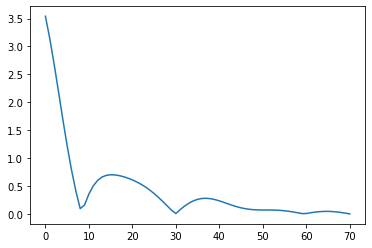

In [5]:
plt.plot(np.arange(iters), errors)
plt.show()

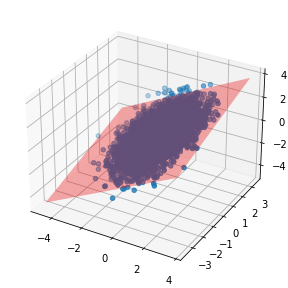

In [6]:
%matplotlib widget

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(projection="3d")
x1 = np.linspace(x[:,0].min(), x[:,0].max(), 100)
y1 = np.linspace(x[:,1].min(), x[:,1].max(), 100)
X, Y = np.meshgrid(x1, y1)

Xp = np.concatenate(
    [
        np.ones(X.shape).ravel()[:, np.newaxis],
        X.ravel()[:, np.newaxis], 
        Y.ravel()[:, np.newaxis]
    ],
    axis=1
)

Z = np.dot(Xp, thetas).reshape((100, 100))

ax.scatter(x[:, 0], x[:, 1], y, c='C0')
ax.plot_surface(X, Y, Z, color='red', alpha=0.35)
fig.tight_layout()
